# 权重衰减(Weight Decay)

## 防止过拟合机制
1. **引入额外损失函数**
    - 权重衰减在模型原损失函数基础上,添加一个关于权重参数的L2正则化项:```L = 原损失函数 + λ * Σ(权重的L2范数)```
    - 这个额外的正则化项惩罚了权重 参数取较大的值,起到防止过拟合的作用。
1. **惩罚大权重**
    - 权重衰减直接惩罚了较大的权重值,迫使网络优化向着较小的权重方向进行。
    - 较小的权重可以表达更简单平滑的函数,防止对训练数据过度拟合。
2. **L2参数正则化**
    - 从数学上看,权重衰减实际上给权重参数添加了L2正则化项,限制了权重的大小。
    - 这增加了模型的稳定性,避免权重参数取值分散,产生过拟合。
3. **去噪效果**
    - 权重衰减可以自动过滤掉那些对应较小权重(即惩罚较少)的噪声特征。
    - 真正有用的特征对应的权重往往较大。去除噪声特征有助于提升模型泛化能力。
4. **优化效果**  
    - 从优化视角看,权重衰减可以提高目标函数的条件数,使其更易优化,避免陷入鞍点或局部最优解。
## 总结

- 权重衰减是一个简单易用、计算高效的正则化技术。
- 它通过多种机制帮助模型防止过拟合,提高泛化能力。
- 在大多数深度神经网络模型中,权重衰减都是必不可少的技术之一。

## 详细实现

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
# 生成训练集数据
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
# 生成测试集数据
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
# 初始化训练的w和b
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [4]:
# 计算L2正则化Penalty的函数
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2
    # L1正则化
    # return torch.sum(torch.abs(w))

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.03
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[
                            5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的l2范数是:', torch.norm(w).item())

w的l2范数是: 14.386606216430664


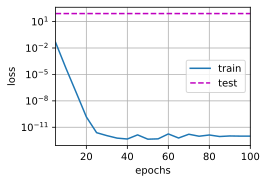

In [6]:
train(lambd=0)

w的l2范数是: 0.03371639549732208


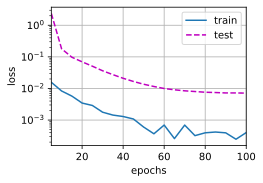

In [7]:
train(lambd=3)

## 简洁实现

In [8]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {'params': net[0].weight, 'weight_decay': wd},
        {'params': net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数:', net[0].weight.norm().item())

w的L2范数: 13.525989532470703


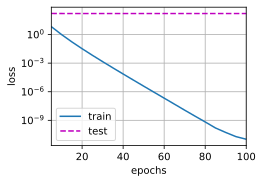

In [9]:
train_concise(0)

w的L2范数: 0.39293062686920166


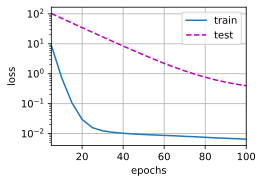

In [10]:
train_concise(3)